# Multidimensional Transmission Spectra with TRIDENT

This tutorial demonstrates how to generate 2D transmission spectra forward models. 

TRIDENT can generate spectra for two different classes of 2D models: (i) atmospheres with day-night temperature, composition, and cloud variations; or (ii) atmospheres with morning-evening terminator variations (but uniform along the day-night transition).

### Example: A 2D Ultra-hot Jupiter

Let's begin by considering a 2D model of an ultra-hot Jupiter. For this example, we'll use planetary properties for WASP-121b ($T_{\rm{eq}}$ = 2450 K).

We start by specifying the star and planet properties:

In [30]:
from POSEIDON.core import create_star, create_planet
from POSEIDON.constants import R_Sun, R_J
import numpy as np

#***** Define stellar properties *****#

R_s = 1.46*R_Sun      # Stellar radius (m)
T_s = 6776.0          # Stellar effective temperature (K)
Met_s = 0.13          # Stellar metallicity [log10(Fe/H_star / Fe/H_solar)]
log_g_s = 4.24        # Stellar log surface gravity (log10(cm/s^2) by convention)

# Create the stellar object
star = create_star(R_s, T_s, log_g_s, Met_s)

#***** Define planet properties *****#

planet_name = 'WASP-121b'  # Planet name used for plots, output files etc.

R_p = 1.753*R_J      # Planetary radius (m)
log_g_p = 2.97       # Gravitational field of planet (cgs)
T_eq = 2450          # Equilibrium temperature (K)

# Create the planet object
planet = create_planet(planet_name, R_p, log_g = log_g_p, T_eq = T_eq)

#### A 2D Day-Night Gradient Model

For 2D models with day-night temperature and/or chemical composition gradients, we need to provide a few more model settings to the ``define_model`` function:

* ``𝗧𝘄𝗼𝗗_𝘁𝘆𝗽𝗲`` is a string identifying whether the 2D model is for day-night variations ('D-N') or evening-morning terminator variations ('E-M'). The second case is covered later in this tutorial.
* ``𝗣𝗧_𝗱𝗶𝗺`` is an integer specifying the dimensionality of the pressure-temperature profile. For 2D models, ``PT_dim = 2``.
* ``𝗫_𝗱𝗶𝗺`` is an integer specifying the dimensionality of the chemical mixing ratios. If you want the abundance of *any* chemical species to vary between the regions, set ``X_dim = 2``. Note: you don't need both ``PT_dim`` and ``X_dim`` to equal 2 for a 2D model (e.g. ``PT_dim = 2`` and ``X_dim = 1`` would have a day-night temperature gradient but uniform abundances between the dayside and nightside).
* ``𝘀𝗽𝗲𝗰𝗶𝗲𝘀_𝗗𝗡_𝗴𝗿𝗮𝗱𝗶𝗲𝗻𝘁`` is a list specifying which included chemical species will vary in abundance between the dayside and nightside (when ``X_dim = 2``).

Let's define a model atmosphere with a day-night temperature gradient containing $\rm{H}^{-}$, $\rm{H}_2 \rm{O}$, and $\rm{CO}$. We'll allow $\rm{H}^{-}$ and $\rm{H}_2 \rm{O}$ to vary between the dayside and nightside, but assume $\rm{CO}$ has a uniform abundance.

In [31]:
from POSEIDON.core import define_model

#***** Define model *****#

model_name = '2D_Ultra-hot'  # Model name used for plots, output files etc.

bulk_species = ['H2', 'He']            # H2 + He comprises the bulk atmosphere
param_species = ['H-', 'H2O', 'CO']    # The trace gases are H-, H2O and CO

# Specify which chemical species vary in abundance between the dayside and nightside
DN_vary = ['H-', 'H2O']   # Only H- and H2O change from day to night

# Create the model object
model = define_model(model_name, bulk_species, param_species, 
                     PT_profile = 'gradient', X_profile = 'isochem',   # P-T profiles with a vertical gradient, mixing ratios uniform with pressure
                     TwoD_type = 'D-N', PT_dim = 2, X_dim = 2, 
                     species_DN_gradient = DN_vary)

# Check the free parameters defining this model
print("Free parameters: " + str(model['param_names']))

Free parameters: ['R_p_ref' 'T_bar_DN_high' 'Delta_T_DN_high' 'T_deep' 'log_H-_bar_DN'
 'Delta_log_H-_DN' 'log_H2O_bar_DN' 'Delta_log_H2O_DN' 'log_CO' 'beta']


We see that this 2D model is defined by 10 parameters. The P-T profile is defined by the terminator temperature at the top of the atmosphere, $\bar{T}_{\rm{DN}, \, high}$, the temperature difference between the dayside and nightside at the top of the atmosphere, $\Delta T_{\rm{DN}, \, high}$, and the temperature in the deep atmosphere, $T_{\rm{deep}}$. Similarly, the abundance profiles for $\rm{H}^{-}$ and $\rm{H}_2 \rm{O}$ are defined by the terminator (log) abundance and the difference between the dayside and nightside (log) abundances. Since we assumed $\rm{CO}$ has a uniform abundance, it only requires one parameter. Finally, $\beta$ is the *opening angle* between the dayside and nightside.

Now let's specify the required parameters and generate this 2D atmosphere.

In [41]:
from POSEIDON.core import make_atmosphere
import numpy as np

# Specify the pressure grid of the atmosphere
P_min = 1.0e-9    # 0.1 ubar
P_max = 100       # 100 bar
N_layers = 100    # 100 layers

# We'll space the layers uniformly in log-pressure
P = np.logspace(np.log10(P_max), np.log10(P_min), N_layers)

# Specify the reference pressure and radius
P_ref = 10.0   # Reference pressure (bar)
R_p_ref = R_p  # Radius at reference pressure

# Provide a specific set of model parameters for the atmosphere 
PT_params = np.array([1800, 1000, 2200])                    # T_bar_DN, Delta_T_DN, T_deep
log_X_params = np.array([-10.0, +4.0, -4.3, -2.0, -3.0])    # log(H-), Delta(H-), log(H2O), Delta(H2O), log(CO)
geometry = np.array([20])                                   # Opening angle Beta (in degrees)
N_slices = 10                  # Number of discrete slices over terminator transition (angular width = N/beta), defaults to 4 if not specified

# Generate the atmosphere
atmosphere = make_atmosphere(planet, model, P, P_ref, R_p_ref, 
                             PT_params, log_X_params, geometry_params = geometry,
                             N_slice_DN = N_slices)

Let's see what this 2D atmosphere look like:

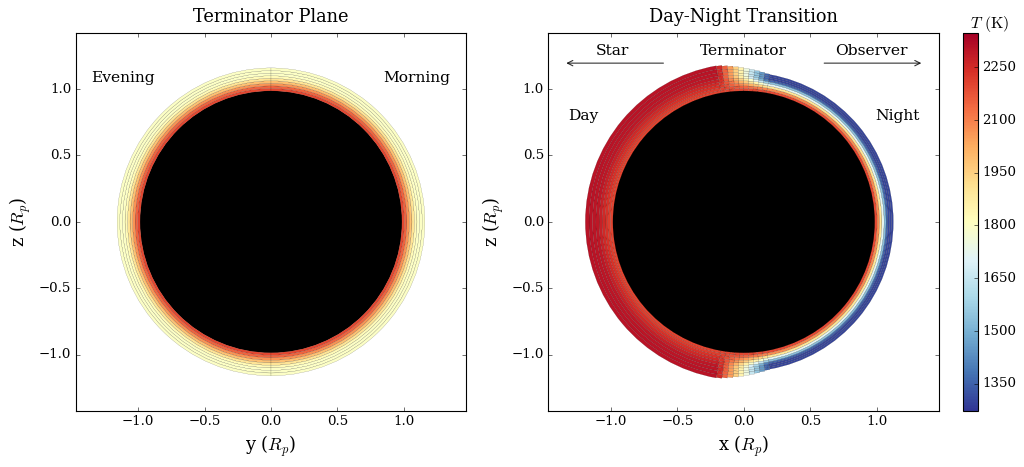

In [33]:
from POSEIDON.visuals import plot_geometry

# Produce plots of atmospheric properties
fig_geom = plot_geometry(planet, star, model, atmosphere)

We see a temperature gradient between the upper atmosphere of the dayside and nightside, with the transition occurring linearly over a 20° opening angle. This plot is *to scale*, demonstrating that the dayside atmosphere of ultra-hot Jupiters is much more spatially extended than the nightside.

The panel on the left is a slice through the terminator plane, which demonstrates that the temperature profile is the same for all angles about the observer's line of sight (i.e. this model is 2D because it assumes azithumal symmetry).

We can also plot the dayside, terminator, and nightside P-T profiles separately:

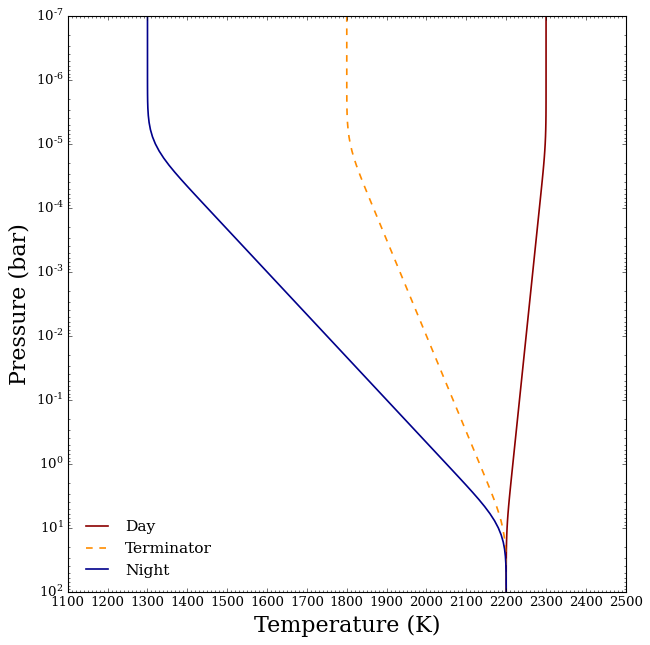

In [34]:
from POSEIDON.visuals import plot_PT

fig_PT = plot_PT(planet, model, atmosphere, 
                 log_P_min = -7,
                 show_profiles = ['day', 'terminator', 'night'])


We see that the two parameters $\bar{T}_{\rm{DN}, \, high}$ and $T_{\rm{deep}}$ define the vertical temperature profile of the terminator plane, which is here assumed to vary linearly (in log pressure) from $10^{-5}$ to $10 \, \rm{bar}$. The third parameter, $\Delta T_{\rm{DN}, \, high}$, then specifies the temperature difference between the dayside and nightside and hence fully determines the dayside and nightside P-T profiles (when we assume they converge in the deep atmosphere). See [MacDonald & Lewis (2022)](https://ui.adsabs.harvard.edu/abs/2022ApJ...929...20M/abstract) for further details on this P-T profile parametrisation.

Similarly, we can plot the mixing ratio profiles:


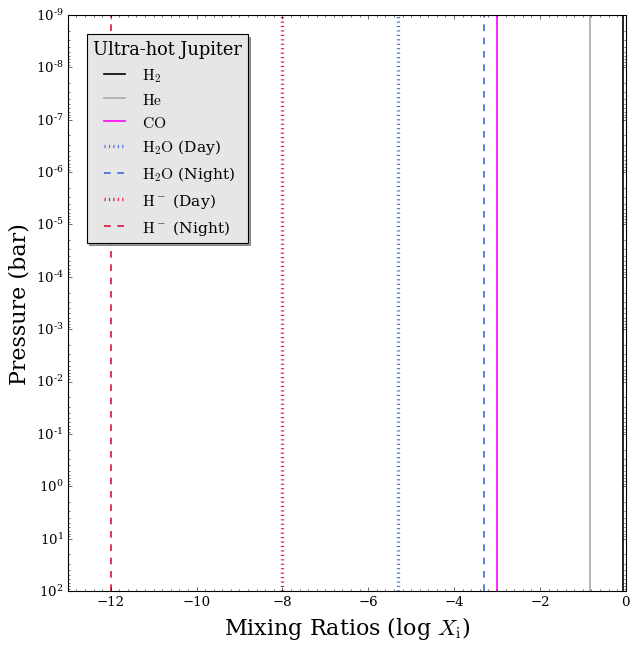

In [35]:
from POSEIDON.visuals import plot_chem

fig_chem = plot_chem(planet, model, atmosphere,
                     plot_species = ['H2', 'He', 'CO', 'H2O', 'H-'],
                     colour_list = ['black', 'darkgrey', 'magenta',
                                    'royalblue', 'crimson'],
                     show_profiles = ['day', 'night'],      # Just plot the day and night profiles to reduce clutter
                     legend_title = 'Ultra-hot Jupiter', 
                     legend_location = 'upper left')   

Our chosen mixing ratio profiles have $\rm{H}^{-}$ being four orders of magnitude less abundant on the nightside than the dayside (since $\rm{H}^{-}$ is expected to be less abundant at lower temperatures), whilst $\rm{H}_2 \rm{O}$ is two orders of magnitude less abundant on the dayside (due to thermal dissociation). Though this is a simple toy model, it suffices to demonstrate below the impact of day-night composition gradients on transmission spectra. 

#### Computing 2D Transmission Spectra with Day-Night Gradients

TRIDENT computes multidimensional transmission spectra using exactly the same functions as we saw in the previous tutorial for 1D models.

We first pre-interpolate the cross sections — don't forget to set ``T_fine`` to encompass the full range of temperatures in the atmosphere (e.g. by examining the P-T profile plot above).

In [36]:
from POSEIDON.core import read_opacities, wl_grid_constant_R

#***** Wavelength grid *****#
 
wl_min = 0.6      # Minimum wavelength (um)
wl_max = 5.3      # Maximum wavelength (um)
R = 10000          # Spectral resolution of grid

wl = wl_grid_constant_R(wl_min, wl_max, R)

#***** Read opacity data *****#

opacity_treatment = 'opacity_sampling'

# Define fine temperature grid (K)
T_fine_min = 1200    # Colder than the nightside
T_fine_max = 2400    # Hotter than the dayside
T_fine_step = 10     # 10 K steps are a good tradeoff between accuracy and RAM

T_fine = np.arange(T_fine_min, (T_fine_max + T_fine_step), T_fine_step)

# Define fine pressure grid (log10(P/bar))
log_P_fine_min = -6.0   # 1 ubar is the lowest pressure in the opacity database
log_P_fine_max = 2.0    # 100 bar is the highest pressure in the opacity database
log_P_fine_step = 0.2   # 0.2 dex steps are a good tradeoff between accuracy and RAM

log_P_fine = np.arange(log_P_fine_min, (log_P_fine_max + log_P_fine_step), 
                       log_P_fine_step)

# Now we can pre-interpolate the sampled opacities (may take up to a minute)
opac = read_opacities(model, wl, opacity_treatment, T_fine, log_P_fine)

Reading in cross sections in opacity sampling mode...
H2-H2 done
H2-He done
H-bf done
H2O done
CO done
Opacity pre-interpolation complete.


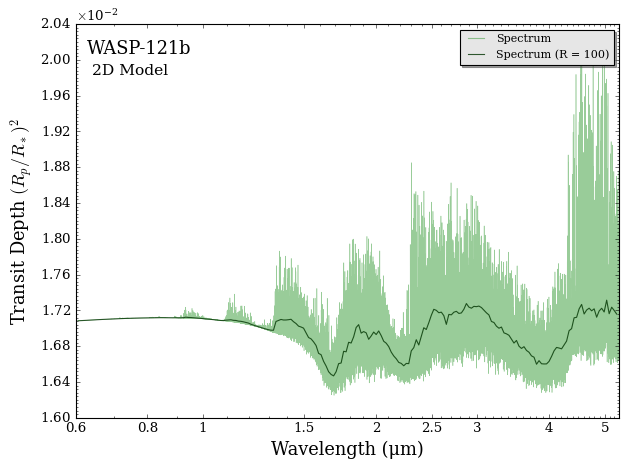

In [39]:
from POSEIDON.core import compute_spectrum
from POSEIDON.visuals import plot_spectra
from POSEIDON.utility import plot_collection

# Generate our 2D transmission spectrum
spectrum_2D = compute_spectrum(planet, star, model, atmosphere, opac, wl,
                              spectrum_type = 'transmission')

# Add the spectrum to an empty spectra plot collection
spectra = plot_collection(spectrum_2D, wl, collection = [])

# Produce figure and save to file
fig = plot_spectra(spectra, planet, model, R_to_bin = 100,
                   plt_label = '2D Model')

Alright, here's where the fun begins! Now we can address interesting science questions, such as:

1. How important are 2D effects in shaping transmission spectra of ultra-hot Jupiters? 

One way to study this question is to disable the 2D temperature and composition gradients and compare with the equivalent 1D spectrum of this planet (i.e. the spectrum of planet with the same P-T profile and chemical composition as the terminator plane, but uniform throughout the day-night line of sight). We can readily do this by setting the 'Delta' parameters to zero and generating a new spectrum. 

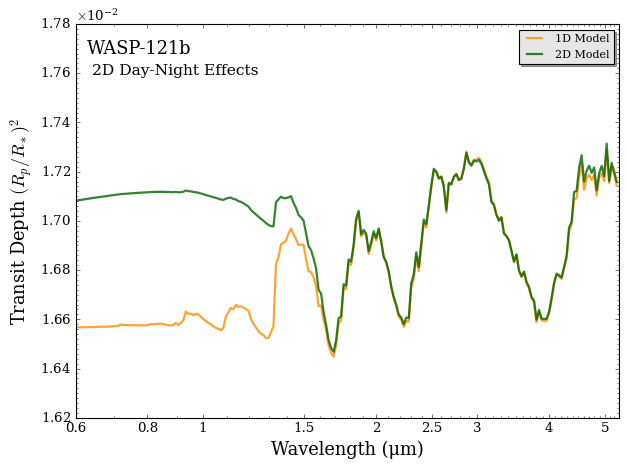

In [9]:
# Define new parameter arrays for thr 1D atmosphere
PT_params_1D = np.array([1800, 0.0, 2200])                          # Delta_T_DN = 0
log_X_params_1D = np.array([-10.0, 0.0, -4.3, 0.0, -3.0])           # Delta log (H-) = 0 and Delta log(H2O) = 0

# Create a new 1D atmosphere
atmosphere_1D = make_atmosphere(planet, model, P, P_ref, R_p_ref, 
                                PT_params_1D, log_X_params_1D, 
                                geometry_params = geometry,
                                N_slice_DN = N_slices)

# Generate the 1D transmission spectrum
spectrum_1D = compute_spectrum(planet, star, model, atmosphere_1D, 
                               opac, wl, spectrum_type = 'transmission')

# Add the two spectra to a plot collection
spectra = []
spectra = plot_collection(spectrum_1D, wl, collection = spectra)
spectra = plot_collection(spectrum_2D, wl, collection = spectra)

# Produce figure and save to file
fig_spec = plot_spectra(spectra, planet, R_to_bin = 100, plot_full_res = False,
                        transit_depth_min = 1.62e-2, transit_depth_max = 1.78e-2,
                        spectra_labels = ['1D Model', '2D Model'],
                        colour_list = ['darkorange', 'darkgreen'],
                        plt_label = '2D Day-Night Effects')


As seen above, 2D effects can produce rather significant differences. In this case, the large $\rm{H}^{-}$ abundance gradient between the dayside and nightside produces the substantial spectral differences at optical wavelengths (though 2D effects are present throughout the modelled wavelength range). 

The plot above folds the impact of temperature and composition gradients into a single '1D vs. 2D' comparison. However, you can also consider more specific science questions, such as:

2. How different would the spectrum look without the $\rm{H}^{-}$ and $\rm{H}_2 \rm{O}$ day-night chemical gradients (but keeping the temperature gradient)?

We can address this question by generating spectra with $\Delta \log \rm{H^{-}_{DN}} = 0$ and $\Delta \log \rm{H_2 O_{DN}} = 0$, respectively.


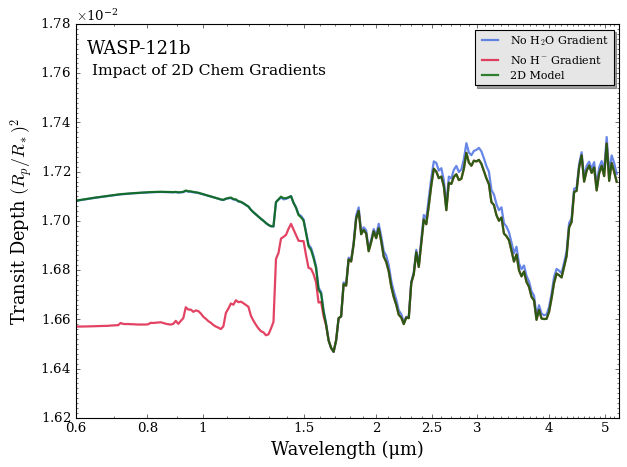

In [10]:
# Define new mixing ratio parameter arrays
log_X_params_no_H2O_gradient = np.array([-10.0, +4.0, -4.3, 0.0, -3.0])          # Delta log(H2O) = 0
log_X_params_no_Hminus_gradient = np.array([-10.0, 0.0, -4.3, -2.0, -3.0])       # Delta log(H-) = 0

# Create new atmospheres
atmosphere_no_H2O_gradient = make_atmosphere(planet, model, P, P_ref, R_p_ref, 
                                             PT_params, log_X_params_no_H2O_gradient, 
                                             geometry_params = geometry,
                                             N_slice_DN = N_slices)
atmosphere_no_Hminus_gradient = make_atmosphere(planet, model, P, P_ref, R_p_ref, 
                                                PT_params, log_X_params_no_Hminus_gradient, 
                                                geometry_params = geometry,
                                                N_slice_DN = N_slices)

# Generate the new transmission spectra
spectrum_no_H2O_gradient = compute_spectrum(planet, star, model, atmosphere_no_H2O_gradient, 
                                            opac, wl, spectrum_type = 'transmission')
spectrum_no_Hminus_gradient = compute_spectrum(planet, star, model, atmosphere_no_Hminus_gradient, 
                                               opac, wl, spectrum_type = 'transmission')

# Add the three spectra to a plot collection
spectra = []
spectra = plot_collection(spectrum_no_H2O_gradient, wl, collection = spectra)
spectra = plot_collection(spectrum_no_Hminus_gradient, wl, collection = spectra)
spectra = plot_collection(spectrum_2D, wl, collection = spectra)

# Produce figure and save to file
fig_spec = plot_spectra(spectra, planet, R_to_bin = 100, plot_full_res = False,
                        transit_depth_min = 1.62e-2, transit_depth_max = 1.78e-2,
                        spectra_labels = ['No H$_2$O Gradient', 'No H$^{-}$ Gradient', '2D Model'],
                        colour_list = ['royalblue', 'crimson', 'darkgreen'],
                        plt_label = 'Impact of 2D Chem Gradients')

The differences between these models can be intuitively understood through the fact that the 2D model has a more extended dayside due to its higher temperature.

* Since the 2D model has more $\rm{H}^{-}$ on the dayside than the nightside, removing the composition gradient (i.e. replacing the $\rm{H}^{-}$ abundance throughout the atmosphere with the terminator abundance) lowers the $\rm{H}^{-}$ abundance in the region that contributes most to the spectrum. Hence, the $\rm{H}^{-}$ absorption in the visible and near-IR becomes much weaker without the composition gradient.
* Since the 2D model has *less* $\rm{H}_2 \rm{O}$ on the dayside than the nightside, the 1D model has a higher $\rm{H}_2 \rm{O}$ abundance in the region that contributes most to the spectrum (i.e. the dayside). Hence, the $\rm{H}_2 \rm{O}$ absorption features in the near-IR become stronger without the $\rm{H}_2 \rm{O}$ composition gradient.


The two effects above, combined with the impact of the temperature gradient, explain the differences between our 2D ultra-hot Jupiter model and the 1D terminator plane 'equivalent' spectrum.

### Example: A 2D Warm Neptune

Now let's switch to examine the other type of 2D model: morning-evening asymmetries.

We'll consider a 2D model of a warm Neptune, using planetary properties for HAT-P-26b ($T_{\rm{eq}}$ = 1040 K).

In [43]:
from POSEIDON.core import create_star, create_planet
from POSEIDON.constants import R_Sun, R_J
import numpy as np

#***** Define stellar properties *****#

R_s = 0.87*R_Sun      # Stellar radius (m)
T_s = 5079.0          # Stellar effective temperature (K)
Met_s = -0.04         # Stellar metallicity [log10(Fe/H_star / Fe/H_solar)]
log_g_s = 4.56        # Stellar log surface gravity (log10(cm/s^2) by convention)

# Create the stellar object
star = create_star(R_s, T_s, log_g_s, Met_s)

#***** Define planet properties *****#

planet_name = 'HAT-P-26b'  # Planet name used for plots, output files etc.

R_p = 0.63*R_J      # Planetary radius (m)
g_p = 4.3712        # Gravitational field of planet (m/s^2)
T_eq = 1043.8       # Equilibrium temperature (K)

# Create the planet object
planet = create_planet(planet_name, R_p, gravity = g_p, T_eq = T_eq)

#### A 2D Evening-Morning Gradient Model

The required model settings for 2D evening-morning gradients are similar to those for 2D day-night gradients:

* ``𝗧𝘄𝗼𝗗_𝘁𝘆𝗽𝗲`` is a string identifying whether the 2D model is for day-night variations ('D-N') or evening-morning terminator variations ('E-M'). We'll focus on the latter case here.
* ``𝗣𝗧_𝗱𝗶𝗺`` is an integer specifying the dimensionality of the pressure-temperature profile. For 2D models, ``PT_dim = 2``.
* ``𝗫_𝗱𝗶𝗺`` is an integer specifying the dimensionality of the chemical mixing ratios. If you want the abundance of *any* chemical species to vary between the regions, set ``X_dim = 2``. Note: you don't need both ``PT_dim`` and ``X_dim`` to equal 2 for a 2D model (e.g. ``PT_dim = 2`` and ``X_dim = 1`` would have an evening-morning temperature gradient but uniform abundances around the terminator).
* ``𝘀𝗽𝗲𝗰𝗶𝗲𝘀_𝗘𝗠_𝗴𝗿𝗮𝗱𝗶𝗲𝗻𝘁`` is a list specifying which included chemical species will vary in abundance between the evening and morning terminators (when ``X_dim = 2``).

Let's define a model atmosphere with an evening-morning temperature gradient containing $\rm{H}_2 \rm{O}$, $\rm{CH}_4$, and $\rm{CO}$. For this scenario we are imagining that each terminator lies on opposite sides of the $\rm{CH}_4$ / $\rm{CO}$ equilibrium boundary, such that the $\rm{CH}_4$ and $\rm{CO}$ abundances vary between the morning and evening terminators (but $\rm{H}_2 \rm{O}$ does not).

In [44]:
from POSEIDON.core import define_model

#***** Define model *****#

model_name = '2D_Warm_Neptune'  # Model name used for plots, output files etc.

bulk_species = ['H2', 'He']             # H2 + He comprises the bulk atmosphere
param_species = ['H2O', 'CO', 'CH4']    # The trace gases are H2O, CO, and CH4

# Specify which chemical species vary in abundance between the morning and evening terminators
EM_vary = ['CO', 'CH4']   # Only CO and CH4 change 

# Create the model object
model = define_model(model_name, bulk_species, param_species, 
                     PT_profile = 'gradient', X_profile = 'isochem',
                     TwoD_type = 'E-M', PT_dim = 2, X_dim = 2,    # Now 'EM', not 'DN'
                     species_EM_gradient = EM_vary)               # Now 'EM', not 'DN'

# Check the free parameters defining this model
print("Free parameters: " + str(model['param_names']))

Free parameters: ['R_p_ref' 'T_bar_term_high' 'Delta_T_term_high' 'T_deep' 'log_H2O'
 'log_CO_bar_term' 'Delta_log_CO_term' 'log_CH4_bar_term'
 'Delta_log_CH4_term' 'alpha']


This 2D model also has 10 parameters. The P-T profile is defined by the average terminator temperature at the top of the atmosphere, $\bar{T}_{\rm{term}, \, high}$, the temperature difference between the evening and morning terminators at the top of the atmosphere, $\Delta T_{\rm{term}, \, high}$, and the temperature in the deep atmosphere, $T_{\rm{deep}}$. Similarly, the abundance profiles for $\rm{CO}$ and $\rm{CH}_4$ are defined by the average terminator (log) abundance and the difference between the evening and morning terminator (log) abundances. Since we assumed $\rm{H}_2 \rm{O}$ has a uniform abundance, it only requires one parameter. Finally, $\alpha$ is the *opening angle* between the evening and morning terminators.

Now let's specify the required parameters and generate this 2D atmosphere.

In [45]:
from POSEIDON.core import make_atmosphere
import numpy as np

# Specify the pressure grid of the atmosphere
P_min = 1.0e-9    # 0.1 ubar
P_max = 100       # 100 bar
N_layers = 100    # 100 layers

# We'll space the layers uniformly in log-pressure
P = np.logspace(np.log10(P_max), np.log10(P_min), N_layers)

# Specify the reference pressure and radius
P_ref = 10.0   # Reference pressure (bar)
R_p_ref = R_p  # Radius at reference pressure

# Provide a specific set of model parameters for the atmosphere 
PT_params = np.array([800, 400, 1400])                      # T_bar_term, Delta_T_term, T_deep
log_X_params = np.array([-2.3, -4.5, +4.0, -4.0, -1.5])     # log(H2O), log(CO), Delta(CO), log(CH4), Delta(CH4)
geometry = np.array([40])                                   # Opening angle alpha (in degrees)
N_slices = 10                  # Number of discrete slices over transition (angular width = N/alpha), defaults to 2 if not specified

# Generate the atmosphere
atmosphere = make_atmosphere(planet, model, P, P_ref, R_p_ref, 
                             PT_params, log_X_params, geometry_params = geometry,
                             N_slice_EM = N_slices)     # Now 'EM', not 'DN'

Let's see what this 2D atmosphere look like:

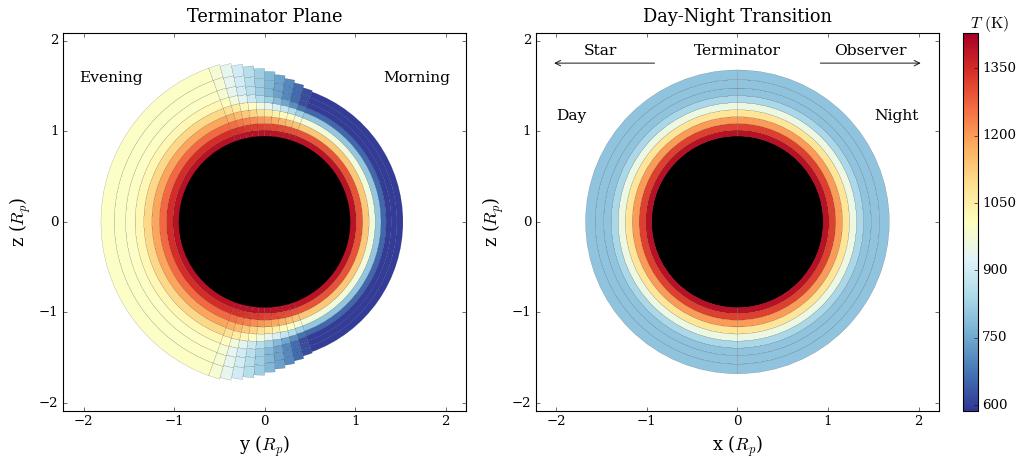

In [23]:
from POSEIDON.visuals import plot_geometry

# Produce plots of atmospheric properties
fig_geom = plot_geometry(planet, star, model, atmosphere)

We see a temperature gradient between the upper atmosphere of the evening and morning terminators, with the transition occurring linearly over a 40° opening angle. This plot is *to scale*, demonstrating that the occulting area of a warm Neptune with 2D terminator gradients can be highly asymmetrical. 

The panel on the right is a slice through the north-south pole plane, which demonstrates that the temperature profile is the same on the dayside and nightside (i.e. this model is 2D because it assumes zenith symmetry about the terminator plane).

We can also plot the evening, average, and morning terminator P-T profiles separately:

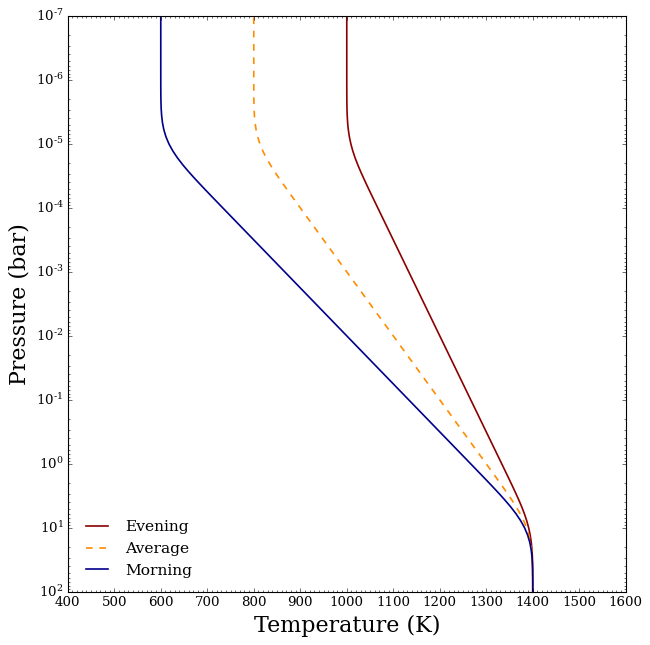

In [29]:
from POSEIDON.visuals import plot_PT

fig_PT = plot_PT(planet, model, atmosphere, 
                 log_P_min = -7,
                 show_profiles = ['evening', 'average', 'morning'])

And the mixing ratio profiles:


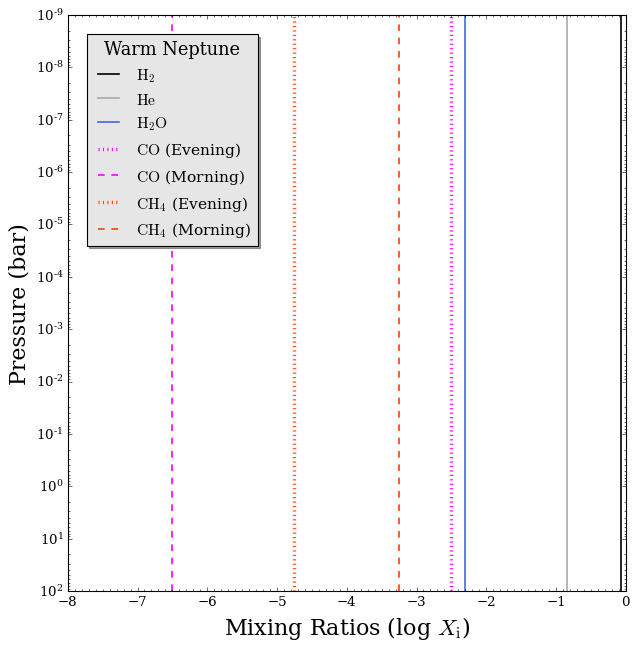

In [24]:
from POSEIDON.visuals import plot_chem

fig_chem = plot_chem(planet, model, atmosphere,
                     plot_species = ['H2', 'He', 'H2O', 'CO', 'CH4'],
                     colour_list = ['black', 'darkgrey', 'royalblue', 
                                    'magenta', 'orangered'],
                     show_profiles = ['evening', 'morning'],      # Just plot the evening and morning profiles to reduce clutter
                     legend_title = 'Warm Neptune', 
                     legend_location = 'upper left')

#### Computing 2D Transmission Spectra with Evening-Morning Gradients

Once a 2D atmosphere is initialised, TRIDENT automatically computes multidimensional transmission spectra using the relevant geometry (either evening-morning terminator or day-night property gradients). So we don't have to change anything (besides the range of ``T_fine``) from how we made the 2D day-night model above! 

In [46]:
from POSEIDON.core import read_opacities, wl_grid_constant_R

#***** Wavelength grid *****#
 
wl_min = 0.6      # Minimum wavelength (um)
wl_max = 5.3      # Maximum wavelength (um)
R = 10000          # Spectral resolution of grid

wl = wl_grid_constant_R(wl_min, wl_max, R)

#***** Read opacity data *****#

opacity_treatment = 'opacity_sampling'

# Define fine temperature grid (K)
T_fine_min = 400    # Colder than the nightside
T_fine_max = 1600    # Hotter than the dayside
T_fine_step = 10     # 10 K steps are a good tradeoff between accuracy and RAM

T_fine = np.arange(T_fine_min, (T_fine_max + T_fine_step), T_fine_step)

# Define fine pressure grid (log10(P/bar))
log_P_fine_min = -6.0   # 1 ubar is the lowest pressure in the opacity database
log_P_fine_max = 2.0    # 100 bar is the highest pressure in the opacity database
log_P_fine_step = 0.2   # 0.2 dex steps are a good tradeoff between accuracy and RAM

log_P_fine = np.arange(log_P_fine_min, (log_P_fine_max + log_P_fine_step), 
                       log_P_fine_step)

# Now we can pre-interpolate the sampled opacities (may take up to a minute)
opac = read_opacities(model, wl, opacity_treatment, T_fine, log_P_fine)

Reading in cross sections in opacity sampling mode...
H2-H2 done
H2-He done
H2-CH4 done
H2O done
CO done
CH4 done
Opacity pre-interpolation complete.


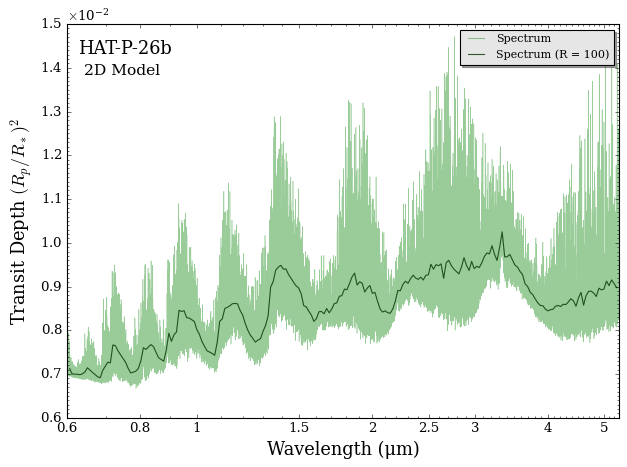

In [25]:
from POSEIDON.core import compute_spectrum
from POSEIDON.visuals import plot_spectra
from POSEIDON.utility import plot_collection

# Generate our 2D transmission spectrum
spectrum_2D = compute_spectrum(planet, star, model, atmosphere, opac, wl,
                              spectrum_type = 'transmission')

# Add the spectrum to an empty spectra plot collection
spectra = plot_collection(spectrum_2D, wl, collection = [])

# Produce figure and save to file
fig = plot_spectra(spectra, planet, model, R_to_bin = 100,
                   plt_label = '2D Model')

Let's examine the same questions as above, but for evening-morning gradients:

1. How important are 2D effects in shaping transmission spectra of warm Neptunes? 

As above, we'll set the temperature and composition 'Delta' parameters to zero to generate a 1D spectrum with the average terminator properties.

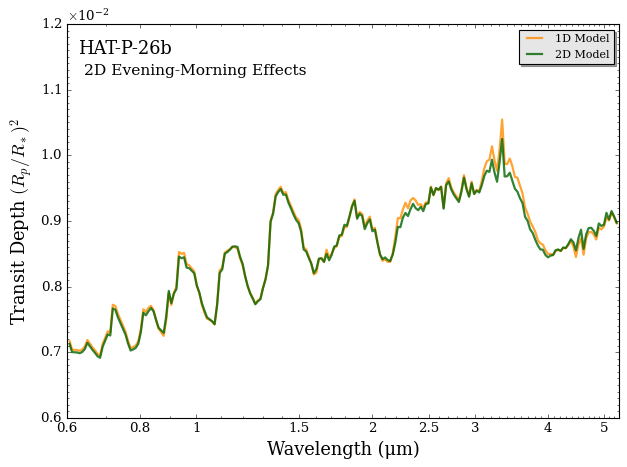

In [26]:
# Define new parameter arrays for thr 1D atmosphere
PT_params_1D = np.array([800, 0.0, 1400])                      # Delta_T_term = 0
log_X_params_1D = np.array([-2.3, -4.5, 0.0, -4.0, 0.0])       # Delta log (CO) = 0 and Delta log(CH4) = 0

# Create a new 1D atmosphere
atmosphere_1D = make_atmosphere(planet, model, P, P_ref, R_p_ref, 
                                PT_params_1D, log_X_params_1D, 
                                geometry_params = geometry,
                                N_slice_EM = N_slices)

# Generate the 1D transmission spectrum
spectrum_1D = compute_spectrum(planet, star, model, atmosphere_1D, 
                               opac, wl, spectrum_type = 'transmission')

# Add the two spectra to a plot collection
spectra = []
spectra = plot_collection(spectrum_1D, wl, collection = spectra)
spectra = plot_collection(spectrum_2D, wl, collection = spectra)

# Produce figure and save to file
fig_spec = plot_spectra(spectra, planet, R_to_bin = 100, plot_full_res = False,
                        transit_depth_min = 0.6e-2, transit_depth_max = 1.20e-2,
                        spectra_labels = ['1D Model', '2D Model'],
                        colour_list = ['darkorange', 'darkgreen'],
                        plt_label = '2D Evening-Morning Effects')


The largest spectral differences are in $\rm{CH}_4$ and $\rm{CO}$ absorption bands (as expected, since these are the molecules with abundance gradients). However, the $\rm{H}_2 \rm{O}$ bands are also affected by the changing scale height around the terminator plane (despite $\rm{H}_2 \rm{O}$ having a uniform abundance in this model).

Let's look at the effects of the composition gradients separately:

2. How different would the spectrum look without the $\rm{CH}_4$ and $\rm{CO}$ evening-morning chemical gradients (but keeping the temperature gradient)?

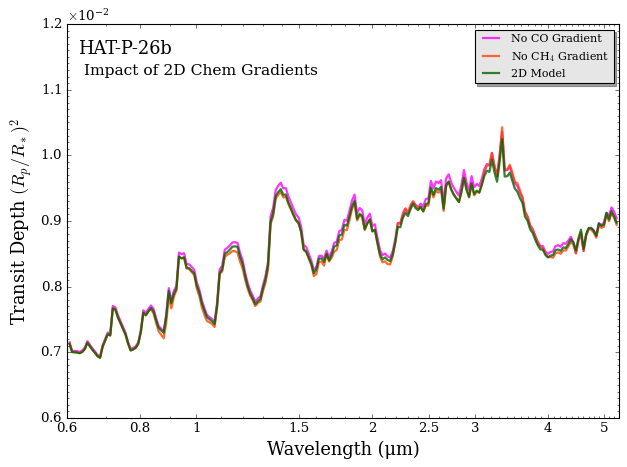

In [28]:
# Define new mixing ratio parameter arrays
log_X_params_no_CO_gradient = np.array([-2.3, -4.5, 0.0, -4.0, -1.5])       # Delta log(CO) = 0
log_X_params_no_CH4_gradient = np.array([-2.3, -4.5, +4.0, -4.0, 0.0])      # Delta log(CH4) = 0

# Create new atmospheres
atmosphere_no_CO_gradient = make_atmosphere(planet, model, P, P_ref, R_p_ref, 
                                            PT_params, log_X_params_no_CO_gradient, 
                                            geometry_params = geometry,
                                            N_slice_EM = N_slices)
atmosphere_no_CH4_gradient = make_atmosphere(planet, model, P, P_ref, R_p_ref, 
                                             PT_params, log_X_params_no_CH4_gradient, 
                                             geometry_params = geometry,
                                             N_slice_EM = N_slices)


# Generate the new transmission spectra
spectrum_no_CO_gradient = compute_spectrum(planet, star, model, atmosphere_no_CO_gradient, 
                                           opac, wl, spectrum_type = 'transmission')
spectrum_no_CH4_gradient = compute_spectrum(planet, star, model, atmosphere_no_CH4_gradient, 
                                            opac, wl, spectrum_type = 'transmission')

# Add the three spectra to a plot collection
spectra = []
spectra = plot_collection(spectrum_no_CO_gradient, wl, collection = spectra)
spectra = plot_collection(spectrum_no_CH4_gradient, wl, collection = spectra)
spectra = plot_collection(spectrum_2D, wl, collection = spectra)

# Produce figure and save to file
fig_spec = plot_spectra(spectra, planet, R_to_bin = 100, plot_full_res = False,
                        transit_depth_min = 0.6e-2, transit_depth_max = 1.2e-2,
                        spectra_labels = ['No CO Gradient', 'No CH$_4$ Gradient', '2D Model'],
                        colour_list = ['magenta', 'orangered', 'darkgreen'],
                        plt_label = 'Impact of 2D Chem Gradients')

The differences between these models are a little trickier to interpret. At heart, many of the differences arise from 2D evening-morning abundance variations impacting the effective area of the transiting exoplanet atmosphere:

* Since the 2D model has a high $\rm{CO}$ in the evening terminator, the mean molecular weight in the evening terminator is higher than for a pure $\rm{H}_2$ + $\rm{He}$ mixture ($\mu \approx 2.3$). Removing the composition gradient lowers the mean molecular weight in the evening terminator, thereby increasing the scale height, and hence increasing the amplitude of most absorption features (even those not due to $\rm{CO}$).
* Since the 2D model has *less* $\rm{CH}_4$ on the evening terminator compared to the morning terminator, removing the composition gradient causes the opposite effect. Using the average (log) $\rm{CH}_4$ abundance throughout the terminator increases the $\rm{CH}_4$ abundance in the evening terminator, thereby decreasing the scale height, and hence weakening the amplitude of most absorption features. The strong $\rm{CH}_4$ band near 3.3 microns is one exception, which becomes *stronger* due to the additional $\rm{CH}_4$ absorption at the evening terminator.

This demonstrates that 2D evening-morning gradients act in multiple ways to shape transmission spectra of planets with asymmetric terminators. Crucially, evening-morning gradients cause distinct spectral imprints compared to day-night gradients (see above), which is the key to disentangling these two distinct clases of planet properties using 3D models.